In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/Knowledge Graphs Course/SpEL.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/SpEL_base.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/UniNER.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/chosen_ids.txt" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/Signal_1M.zip" .

In [3]:
! unzip -q "/content/UniNER.zip"
! unzip -q "/content/SpEL.zip"
! unzip -q "/content/SpEL_base.zip"
! unzip -q "./Signal_1M.zip"

In [11]:
CHOSEN_IDS_PATH = "/content/chosen_ids.txt"
PRONOUNS = []

# utils

In [5]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
def plot(frequencies, categories, xlabel, title, path):
    import matplotlib.pyplot as plt

    # Fixing random state for reproducibility

    fig, ax = plt.subplots()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Example data
    y_pos = list(range(len(categories)))
    fig.set_size_inches(5, 7)
    ax.barh(y_pos, frequencies, label=frequencies, align='center', color=colors)
    ax.set_yticks(y_pos, labels=categories)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    for i, v in enumerate(frequencies):
        ax.text(v, i, str(v), color='black', verticalalignment='center', fontsize="xx-small", horizontalalignment="right")
    fig.savefig(path, bbox_inches="tight", pad_inches=0.1)

In [7]:
import os
import json
from tqdm import tqdm
import random
def get_filenames(dir_path, chosen_ids_path):
    file_names=[]
    id2idx={}
    i=0
    ids = []
    with open(chosen_ids_path, "r") as f:
        ids = f.readlines()
        ids = [id.strip() for id in ids]

    for id in ids:
        id2idx[id] = len(file_names)
        path = os.path.join(dir_path, id)
        file_names.append((path, id))
    return file_names, id2idx

def read_file(file_name):
    file_jason = open(file_name, encoding="utf-8")
    file_jason = json.load(file_jason)
    return(file_jason)

org_filenames, id2idx_per = get_filenames("/content/UniNER/ORG", CHOSEN_IDS_PATH)
spel_filenames, id2idx_spel = get_filenames("/content/SpEL_base/", CHOSEN_IDS_PATH)
signal_filenames, id2idx_signal = get_filenames("/content/Signal_1M/", CHOSEN_IDS_PATH)

## Entity matching without cleaning

In [9]:
NER_filenames = org_filenames

In [12]:
import re
import pandas as pd
def is_special_case(entity):
    return "*" in entity or "?" in entity or "\\u" in entity or "+" in entity

def get_offsets(entity, sentence):
    if entity.lower() in PRONOUNS:
        entity = " " + entity.lower() + " "
    else:
        entity = f"{entity.lower()}"
    return [(m.start()-1, m.end()-1) for m in re.finditer(entity, sentence.lower())]

def match_entities_in_sentence(ner_output, spel_output, sentence, ignore_func):
    matches = 0
    failures = []
    total_checked = 0
    for named_entity in ner_output:
        if is_special_case(named_entity) or ignore_func(named_entity):
            continue
        try:
            offsets = get_offsets(named_entity, sentence)
            matches_found = 0
            for u, v in offsets:
                for mention in spel_output:
                    start, end = tuple(mention["span"])
                    if max(u, start) <= min(v, end):
                        matches_found += 1
                        break

            total_checked += len(offsets)
            if matches_found == 0:
                failures.append({"Named Entity": named_entity, "Sentence" : sentence, "Spel": spel_output})
            else:
                 matches += matches_found
        except Exception as e:
            print(e, named_entity, "|||||", sentence)
            pass

    return matches, total_checked, failures

def match_entities_in_datasets(ignore_func=lambda ne: False):
    total_matches = 0
    total_entities = 0
    not_found = []
    for idx in tqdm(range(len(NER_filenames))):
        ner_out = read_file(NER_filenames[idx][0])
        spel_out = read_file(spel_filenames[idx][0])
        for i, sent in enumerate(nltk.sent_tokenize(read_file(signal_filenames[idx][0])["content"])):
            matches_count, total_checked, failures = match_entities_in_sentence(ner_out[i], spel_out[i], sent, ignore_func)
            not_found.extend(failures)
            total_matches += matches_count
            total_entities += total_checked


    # df = pd.DataFrame(not_found)
    # df.to_csv("persons_not_found.csv", index=False)
    return total_entities, total_matches, not_found

total_entities, total_matches, not_found = match_entities_in_datasets()

  2%|▏         | 1518/100000 [00:08<07:32, 217.84it/s]

bad escape \c at position 4 TBWA\Chiat\Day ||||| The agency and brand parted ways in 2008, when Pepsi moved its business to another Omnicom shop, TBWA\Chiat\Day.


 17%|█▋        | 17176/100000 [01:19<07:12, 191.33it/s]

bad escape \p at position 4 TBWA\Paris ||||| Action Against Hunger and TBWA\Paris send a smart message just before the 70th General Assembly of the UN    Millions of people in the world live and survive thanks to the actions of aid workers.
bad escape \p at position 4 TBWA\Paris ||||| To bring attention to this crucial issue, Action Against Hunger and its agency TBWA\Paris are launching this clever campaign.


 27%|██▋       | 26883/100000 [02:02<05:19, 228.87it/s]

missing ), unterminated subpattern at position 17 Bob Hatch Engine (Electronics ||||| Find out more about TMC online at 2015 TMCSuperTech Station WinnersASE Written TestHarold Wineinger LightingJesse Elmore FastenersBrian Blevins RP ManualChris Barnett Electrical DiagramsTerry Podralski CSA ComplianceTK Kilchenstein, Fleetpro Inc.Electrical #1Terry Podralski Safety and EnvironmentalRudy Laguna Wheel End #1Jasen Weers TorqueDave Thrower Precision MeasuringChris Barnett Coolant/DEFSteven Fraser SafetyDerick Hebert PMIDoug Nickles HVACJeremiah Larrabee DrivetrainDrew Dilmuth Starting and ChargingBrian Blevins Service InformationStephen Radford BrakesRobert Anderson Vehicle Control SystemsLarry Coatney Wheel End #2Brian Blevins Fifth WheelSteve Willis Electrical #2Steve Willis Tire and WheelRuss Whitaker Steering and SuspensionBob Hatch Engine (Electronics)Darek Mowinski Engine (Hardware)Kenneth Bilyea 2015 TMCFutureTech Student Station WinnersASE Written Test Jonathan Kelly Wheel End Cody

 59%|█████▉    | 58842/100000 [04:22<03:44, 183.02it/s]

missing ), unterminated subpattern at position 17 Capital One Bank (USA ||||| It will also share the official National Flex Day badge on its web site and display the National Flex Day poster in its offices.About Capital OneCapital One Financial Corporation ( is a financial holding company whose subsidiaries, which include Capital One, N.A., and Capital One Bank (USA About Working Mother Media Working Mother Media (WMM), a division of Bonnier Corporation (bonnier.com), publishes Working Mother magazine and its companion website, workingmother.com.


 67%|██████▋   | 67371/100000 [04:57<02:08, 253.72it/s]

bad escape (end of pattern) at position 263 National Center\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\ ||||| I also would like to thank Linda Phillips from CAWP and Deborah Wood Smith from the National Center for State Courts for their assistance with the data for this essay.


 73%|███████▎  | 72781/100000 [05:18<01:44, 261.65it/s]

unbalanced parenthesis at position 3 800) 992-0180 ||||| Follow Voya Investment Management on Twitter @VoyaInvestments.SHAREHOLDER INQUIRIES: Shareholder Services at (800) 992-0180; voyainvestments.comTo view the original version on PR Newswire, visit:SOURCE Voya Investment Management


 74%|███████▍  | 73982/100000 [05:23<01:36, 268.87it/s]

unbalanced parenthesis at position 1 4) ||||| 4) is acquiring a competitor (iSatori / $IFIT) that offers additional brands and distribution channels.


 80%|███████▉  | 79758/100000 [05:45<01:00, 336.37it/s]

staff numbers and to meet growing customer demand.


 82%|████████▏ | 81742/100000 [05:52<01:06, 273.11it/s]

unterminated character set at position 23 Calcutta School of trop[ical Medicine ||||| Important Dates:Date & Time of Interview: 18-09-2015 at 11:00 am.Venue: Conference Room (4th Floor), Calcutta School of trop[ical Medicine, 108 C. R. Avenue, KOLKATA-700073.


 84%|████████▍ | 83899/100000 [06:00<01:10, 227.39it/s]

unterminated character set at position 0 [ ||||| The overseer of [.


 95%|█████████▌| 95490/100000 [06:44<00:17, 260.04it/s]

 Inc.


100%|██████████| 100000/100000 [07:02<00:00, 236.80it/s]


In [13]:
total_matches / total_entities

0.33519481815381547

In [14]:
total_matches

386307

In [15]:
total_entities

1152485

##Entity Matching with cleaning

In [16]:
lower_case_names = []
lower_case_freqs = {}
non_lower_freqs = {}
ids = []

total_name_entities = 0
for fn, f_id in tqdm(NER_filenames):
    doc_names = read_file(fn)
    sents = nltk.sent_tokenize(read_file(signal_filenames[id2idx_signal[f_id]][0])["content"])
    for i, snt_names in enumerate(doc_names):
        for name in snt_names:
            if name == "":
                continue
            try:
                occurences = get_offsets(name, sents[i])
            except Exception as e:
                occurances = []
            total_name_entities += len(occurences)

            if name.islower() or name.lower() in PRONOUNS:
                name = name.lower()
                lower_case_names.append((name, f_id))
                lower_case_freqs[name] = lower_case_freqs.get(name, 0) + len(occurences)
            else:
                name = name.lower()
                non_lower_freqs[name] = non_lower_freqs.get(name, 0) + len(occurences)

100%|██████████| 100000/100000 [03:51<00:00, 431.76it/s]


In [17]:
len(lower_case_names)

107344

In [18]:
lower_case_freqs = {k: v for k, v in sorted(lower_case_freqs.items(), key=lambda item: item[1], reverse=True)}

In [19]:
sum([i[1] for i in lower_case_freqs.items() if i[1] > 1])

95400

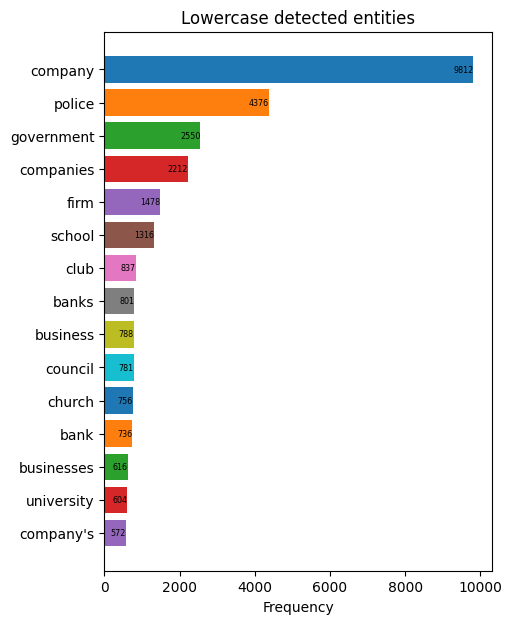

In [21]:
most_frequent = list(lower_case_freqs.items())[:15]
categories = [i[0] for i in most_frequent]
frequencies = [i[1] for i in most_frequent]

plot(frequencies, categories, "Frequency", "Lowercase detected entities", "org_1.jpg")

20 20


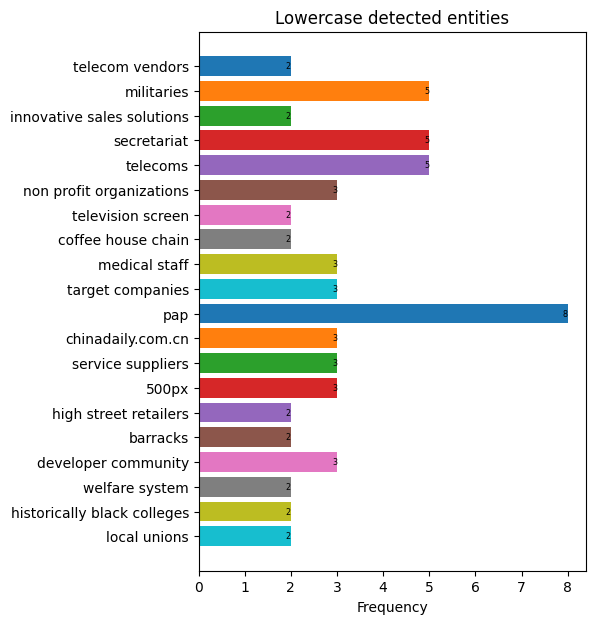

In [22]:
least_frequent = [i for i in lower_case_freqs.items() if i[1] < 10 and i[1] > 1 and "@" not in i[0]]
random.seed(6556)
least_frequent = random.sample(least_frequent, k=20)

categories = [i[0] for i in least_frequent]
frequencies = [i[1] for i in least_frequent]
print(len(categories), len(frequencies))
plot(frequencies, categories, "Frequency", "Lowercase detected entities", "org_2.jpg")

In [23]:
import re
import pandas as pd
def ignore_me(entity):
    return (entity.lower() in lower_case_freqs) and (entity.lower() not in non_lower_freqs)


total_entities, total_matches, not_found = match_entities_in_datasets(ignore_func=ignore_me)

  2%|▏         | 1535/100000 [00:03<03:38, 450.97it/s]

bad escape \c at position 4 TBWA\Chiat\Day ||||| The agency and brand parted ways in 2008, when Pepsi moved its business to another Omnicom shop, TBWA\Chiat\Day.


 17%|█▋        | 17189/100000 [00:53<04:17, 322.07it/s]

bad escape \p at position 4 TBWA\Paris ||||| Action Against Hunger and TBWA\Paris send a smart message just before the 70th General Assembly of the UN    Millions of people in the world live and survive thanks to the actions of aid workers.
bad escape \p at position 4 TBWA\Paris ||||| To bring attention to this crucial issue, Action Against Hunger and its agency TBWA\Paris are launching this clever campaign.


 27%|██▋       | 26902/100000 [01:21<03:30, 346.73it/s]

missing ), unterminated subpattern at position 17 Bob Hatch Engine (Electronics ||||| Find out more about TMC online at 2015 TMCSuperTech Station WinnersASE Written TestHarold Wineinger LightingJesse Elmore FastenersBrian Blevins RP ManualChris Barnett Electrical DiagramsTerry Podralski CSA ComplianceTK Kilchenstein, Fleetpro Inc.Electrical #1Terry Podralski Safety and EnvironmentalRudy Laguna Wheel End #1Jasen Weers TorqueDave Thrower Precision MeasuringChris Barnett Coolant/DEFSteven Fraser SafetyDerick Hebert PMIDoug Nickles HVACJeremiah Larrabee DrivetrainDrew Dilmuth Starting and ChargingBrian Blevins Service InformationStephen Radford BrakesRobert Anderson Vehicle Control SystemsLarry Coatney Wheel End #2Brian Blevins Fifth WheelSteve Willis Electrical #2Steve Willis Tire and WheelRuss Whitaker Steering and SuspensionBob Hatch Engine (Electronics)Darek Mowinski Engine (Hardware)Kenneth Bilyea 2015 TMCFutureTech Student Station WinnersASE Written Test Jonathan Kelly Wheel End Cody

 59%|█████▉    | 58898/100000 [02:41<01:24, 489.00it/s]

missing ), unterminated subpattern at position 17 Capital One Bank (USA ||||| It will also share the official National Flex Day badge on its web site and display the National Flex Day poster in its offices.About Capital OneCapital One Financial Corporation ( is a financial holding company whose subsidiaries, which include Capital One, N.A., and Capital One Bank (USA About Working Mother Media Working Mother Media (WMM), a division of Bonnier Corporation (bonnier.com), publishes Working Mother magazine and its companion website, workingmother.com.


 67%|██████▋   | 67411/100000 [03:01<01:22, 393.39it/s]

bad escape (end of pattern) at position 263 National Center\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\ ||||| I also would like to thank Linda Phillips from CAWP and Deborah Wood Smith from the National Center for State Courts for their assistance with the data for this essay.


 73%|███████▎  | 72801/100000 [03:13<00:59, 458.83it/s]

unbalanced parenthesis at position 3 800) 992-0180 ||||| Follow Voya Investment Management on Twitter @VoyaInvestments.SHAREHOLDER INQUIRIES: Shareholder Services at (800) 992-0180; voyainvestments.comTo view the original version on PR Newswire, visit:SOURCE Voya Investment Management


 74%|███████▍  | 73986/100000 [03:15<00:59, 439.77it/s]

unbalanced parenthesis at position 1 4) ||||| 4) is acquiring a competitor (iSatori / $IFIT) that offers additional brands and distribution channels.


 80%|███████▉  | 79767/100000 [03:29<00:48, 416.62it/s]

staff numbers and to meet growing customer demand.


 82%|████████▏ | 81805/100000 [03:33<00:43, 418.46it/s]

unterminated character set at position 23 Calcutta School of trop[ical Medicine ||||| Important Dates:Date & Time of Interview: 18-09-2015 at 11:00 am.Venue: Conference Room (4th Floor), Calcutta School of trop[ical Medicine, 108 C. R. Avenue, KOLKATA-700073.


 84%|████████▍ | 83887/100000 [03:38<00:40, 400.41it/s]

unterminated character set at position 0 [ ||||| The overseer of [.


 96%|█████████▌| 95508/100000 [04:04<00:09, 483.23it/s]

 Inc.


100%|██████████| 100000/100000 [04:13<00:00, 393.71it/s]


In [24]:
total_matches / total_entities

0.34534486650733304

In [25]:
total_matches, total_entities

(385514, 1116316)

# Cuttoffs

In [26]:
non_lower_freqs = {k: v for k, v in sorted(non_lower_freqs.items(), key=lambda item: item[1], reverse=True)}
for k in non_lower_freqs:
    if k in lower_case_freqs:
        non_lower_freqs[k] += lower_case_freqs[k]

In [ ]:
non_lower_freqs

In [27]:
CUT_OFF_PRECENTAGE = 20 #precent

In [28]:
import re
end_idx = int(len(non_lower_freqs) * CUT_OFF_PRECENTAGE * 0.01)
cutted_off = {k:v for k, v in list(non_lower_freqs.items())[:end_idx]}
matches = {}

def match_entity(named_entity, spel_out, sentence,idx):
    try:
        offsets = get_offsets(named_entity, sentence)
        matches = 0
        for u, v in offsets:
            for mention in spel_out:
                start, end = tuple(mention["span"])
                if max(u, start) <= min(v, end):
                    matches += 1
                    break
        return matches
    except Exception as e:
        print(e, named_entity, spel_out, sentence)
        return 0

for idx in tqdm(range(len(NER_filenames))):
    ner_out = read_file(NER_filenames[idx][0])
    spel_out = read_file(spel_filenames[idx][0])
    for i, sent in enumerate(nltk.sent_tokenize(read_file(signal_filenames[idx][0])["content"])):
        for ne in ner_out[i]:
            if ne.lower() not in cutted_off:
                continue
            matched = match_entity(ne, spel_out[i], sent,NER_filenames[idx])
            matches[ne.lower()] = matches.get(ne.lower(), 0) + matched


overlap_precentage = {}
for key, value in cutted_off.items():
    overlap_precentage[key] = matches.get(key, 0) / value



 18%|█▊        | 17602/100000 [00:26<01:28, 930.84it/s]

nothing to repeat at position 0 +353-1-481-1716 [{'mention': 'General_Electric', 'span': [84, 100], 'phrase': 'General Electric'}, {'mention': 'Johnson_Controls', 'span': [135, 156], 'phrase': 'Johnson Controls, Inc'}, {'mention': 'Schneider_Electric', 'span': [174, 192], 'phrase': 'Schneider Electric'}, {'mention': 'Siemens', 'span': [198, 208], 'phrase': 'Siemens AG'}, {'mention': 'PR_Newswire', 'span': [341, 352], 'phrase': 'PR Newswire'}] Companies Mentioned - ABB Ltd - Comverge, Inc. - Eaton Corporation - Enernoc Inc. - General Electric - Honeywell International, Inc. - Johnson Controls, Inc - Opower, Inc. - Schneider Electric SA - Siemens AG For more information visit  Media Contact: Laura Wood, +353-1-481-1716, press@researchandmarkets.netTo view the original version on PR Newswire, visit:SOURCE Research and Markets


 33%|███▎      | 32998/100000 [00:50<02:04, 538.96it/s]

nothing to repeat at position 0 +353-1-481-1716 [{'mention': 'Robert_Bosch_GmbH', 'span': [205, 210], 'phrase': 'Bosch'}, {'mention': 'Robert_Bosch_GmbH', 'span': [212, 239], 'phrase': 'Bosch Automotive Technology'}, {'mention': 'Delphi_Automotive', 'span': [241, 247], 'phrase': 'Delphi'}, {'mention': 'Johnson_Controls', 'span': [390, 406], 'phrase': 'Johnson Controls'}, {'mention': 'PR_Newswire', 'span': [700, 711], 'phrase': 'PR Newswire'}] Key Vendors Continental Pacific Industrial Schrader Electronics Other Prominent Vendors Advantage PressurePro Enterprises ALLIGATOR Ventilfabrik Alps Electric Bartec USA  Bendix Commercial Vehicle Systems Bosch (Bosch Automotive Technology) Delphi Automotive Dill Air Control Products Doran Manufacturing Freescale Semiconductor Hella Ireland  Huf Electronics Bretten Infineon Technologies Johnson Controls Murata Electronics Oy NIRA Dynamics Orange Electronic North America Silicon Microstructures Standard Motor Products Transense Technologies Valor T

 39%|███▉      | 38896/100000 [01:01<01:39, 613.09it/s]

nothing to repeat at position 0 +353-1-481-1716 [{'mention': 'Amway', 'span': [97, 102], 'phrase': 'Amway'}, {'mention': 'Panasonic', 'span': [367, 388], 'phrase': 'Panasonic Corporation'}, {'mention': 'Unilever', 'span': [453, 461], 'phrase': 'Unilever'}, {'mention': 'PR_Newswire', 'span': [621, 632], 'phrase': 'PR Newswire'}] Strategic Recommendations Companies Mentioned - 3M Purification Inc. - A. O. Smith Corporation - Amway Corporation - Aquaphor - Blue Filters Group - Coway Co., Ltd. - Culligan International Company - Eco Water Systems LLC - Eureka Forbes Limited - Helen Of Troy Limited - Ihlas Home Appliances A.S. - Kent RO Systems - LG Electronics, Inc. - Midea Water Appliances - Panasonic Corporation - Pentair Inc. - Sun Water Systems, Inc. - The Clorox Company - Unilever - Whirlpool Corporation For more information visit   Media Contact: Laura Wood , +353-1-481-1716, press@researchandmarkets.net To view the original version on PR Newswire, visit:  SOURCE  Research and Markets

 48%|████▊     | 48054/100000 [01:17<01:34, 549.50it/s]

nothing to repeat at position 0 +353-1-481-1716 [{'mention': 'Shanghai', 'span': [96, 104], 'phrase': 'Shanghai'}, {'mention': "People's_Republic_of_China", 'span': [139, 144], 'phrase': 'China'}, {'mention': "People's_Republic_of_China", 'span': [226, 231], 'phrase': 'China'}, {'mention': 'Guangdong', 'span': [239, 248], 'phrase': 'Guangdong'}, {'mention': 'PR_Newswire', 'span': [528, 539], 'phrase': 'PR Newswire'}] Strategic Recommendations Companies Mentioned - A. Schulman Asia Limited - Ampacet Masterbatch (Shanghai) Manufacturing Co., Ltd. - Cabot (China) Limited - Changzhou Hongmei Plastic Masterbatch Co., Ltd. - Clariant Chemicals (China) Ltd - Guangdong Charming Co., Ltd - Malion New Materials Co., Ltd - Ngai Hing Hong Company Limited - PolyOne Shanghai Co., Ltd - Yangxi Huaqiang Color Master Batch Factory For more information visit  Media Contact: Laura Wood , +353-1-481-1716, [email protected] To view the original version on PR Newswire, visit: SOURCE Research and Markets


 57%|█████▋    | 56762/100000 [01:31<01:18, 552.02it/s]

nothing to repeat at position 0 +353-1-481-1716 [{'mention': '3M', 'span': [24, 26], 'phrase': '3M'}, {'mention': 'Apple_Inc.', 'span': [29, 34], 'phrase': 'Apple'}, {'mention': 'Philips', 'span': [259, 266], 'phrase': 'Philips'}, {'mention': 'Science_Applications_International_Corporation', 'span': [325, 329], 'phrase': 'SAIC'}, {'mention': 'Samsung', 'span': [332, 339], 'phrase': 'Samsung'}, {'mention': 'Sigma-Aldrich', 'span': [374, 387], 'phrase': 'Sigma-Aldrich'}, {'mention': 'Sony', 'span': [390, 394], 'phrase': 'Sony'}, {'mention': 'PR_Newswire', 'span': [574, 585], 'phrase': 'PR Newswire'}, {'mention': 'PR_Newswire', 'span': [642, 653], 'phrase': 'PR Newswire'}] Quantum Dot Companies - 3M - Apple - Evident Technologies - Fisher Scientific - InVisage - Kateeva - LG Display - Life Technologies Corp - N-N Labs - NanoAxis - NanoPhotonica - Nanoco Technologies - Nanosys - Neophotonics - Nexxus Lighting - Ocean Nanotech - Philips / MMD - QD Laser/Fujitsu - QD Vision - Quantum Materia

100%|██████████| 100000/100000 [02:43<00:00, 613.27it/s]


In [29]:
overlap_precentage

{'twitter': 0.7457349529138801,
 'pr newswire': 0.5829704159783752,
 'facebook': 0.7719589495925143,
 'company': 0.0027580772261623326,
 'apple': 0.7453654378862135,
 'nasdaq': 0.4892399267399267,
 'eu': 0.18470728793309438,
 'nyse': 0.2946763309172707,
 'google': 0.7648159700561448,
 'un': 0.23811043728056175,
 'reuters': 0.8261287223823247,
 'nfl': 0.6160896130346232,
 'police': 0.01741534208707671,
 'the company': 0.0,
 'congress': 0.7979529946929492,
 'fed': 0.7497612225405922,
 'instagram': 0.8124685771744595,
 'sec': 0.09049516220830962,
 'cnn': 0.8292971057294743,
 'the sydney morning herald': 0.9988151658767772,
 'amazon': 0.7856294536817102,
 'microsoft': 0.8157575757575758,
 'government': 0.015628756912719404,
 'volkswagen': 0.8186738836265224,
 'labour': 0.7726344452008169,
 'youtube': 0.818374558303887,
 'islamic state': 0.7346007604562738,
 'afp': 0.38631178707224334,
 'is': 0.16296863045141546,
 'chelsea': 0.9021310181531176,
 'prnewswire': 0.8110047846889952,
 'fifa': 0.

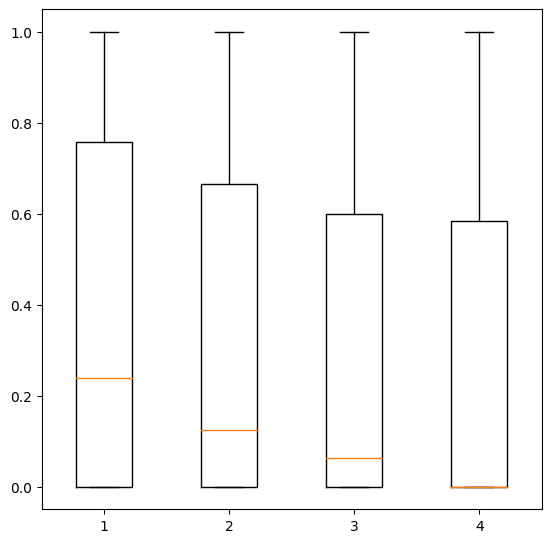

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


overlap = [i[1] for i in list(overlap_precentage.items())]
data= [
       overlap[:int(len(overlap) * 0.25)],
       overlap[:int(len(overlap) * 0.5)],
       overlap[:int(len(overlap) * 0.75)],
       overlap[:int(len(overlap) * 1)]]

fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
plt.show()

In [ ]:
plt.savefig("org_")

In [32]:
import pickle

with open("overlap_org.pkl", "wb") as f:
    pickle.dump(overlap_precentage, f)

In [33]:
!mv overlap_org.pkl "/content/drive/MyDrive/Knowledge Graphs Course/Overlap"